# COVID Analysis

This is Part 1 of our Covid data analysis. Here, we will be using the process of map-reduce to determine the amount of males vs females who contracted covid, how many of each gender passed away, and how many of each gender were hospitalized. We will also investigate amongst those who passed away whether they had a pre-existing condition or not.

---

In [1]:
%%file bigdata.py

from mrjob.job import MRJob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import exp
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

class map_read(MRJob):
    def mapper(self, _, line):
        line = line.split(",")
        if line[2] == "1":
            yield "Female", (line[3], line[4], line[6], line[9], line[10], 
                             line[11], line[12], line[13], line[14],
                             line[15], line[16], line[17], line[18])
        else:
            yield "Male", (line[3], line[4], line[6], line[9], line[10], 
                           line[11], line[12], line[13], line[14],
                           line[15], line[16], line[17], line[18])
            
    def reducer(self, key, values):
        if key == "Female":
            fdeaths = 0
            fcount = 0
            fhospitalized = 0
            fpreexisting = 0
            '''
                index indicates which condition is present in person
                pneumonia, diabetes, copd, asthma, immunosuppressed, hypertension, other, 
                cardiovascular, obesity, renal, tobacco   
            '''
            fcondition = [0,0,0,0,0,0,0,0,0,0,0]
            for x in values:
                fcount += 1
                if x[0] == "1":
                    fhospitalized += 1
                if x[1] != "9999-99-99":
                    fdeaths += 1
                if "1" in x[2:-1]:
                    fpreexisting += 1
                for i in range(len(x[2:-1]) + 1):
                    if x[i + 2] == "1" and x[1] != "9999-99-99":
                        fcondition[i] += 1
                        
            yield "Female Stats", {"count": fcount, "deaths": fdeaths, 
                                   "hospitalized": fhospitalized,
                                   "pre-existing condition": fpreexisting}
            yield "Death Stats", {
            "Female": {
            "deaths": fdeaths,
            "hospitalized": fhospitalized,
            "conditions": {
                "pneumonia": fcondition[0],
                "diabetes": fcondition[1],
                "copd": fcondition[2],
                "asthma": fcondition[3],
                "immunosuppressed": fcondition[4],
                "hypertension": fcondition[5],
                "other": fcondition[6],
                "cardiovascular": fcondition[7],
                "obesity": fcondition[8],
                "renal": fcondition[9],
                "tobacco": fcondition[10]      
                }
            }}
        
        else:
            mdeaths = 0
            mcount = 0
            mhospitalized = 0
            mpreexisting = 0
            '''
                index indicates which condition is present in person
                pneumonia, diabetes, copd, asthma, immunosuppressed, hypertension, other, 
                cardiovascular, obesity, renal, tobacco   
            '''
            mcondition = [0,0,0,0,0,0,0,0,0,0,0]
            for x in values:
                mcount += 1
                if x[0] == "1":
                    mhospitalized += 1
                if x[1] != "9999-99-99":
                    mdeaths += 1
                if "1" in x[2:-1]:
                    mpreexisting += 1
                for i in range(len(x[2:-1]) + 1):
                    if x[i + 2] == "1" and x[1] != "9999-99-99":
                        mcondition[i] += 1
            yield "Male Stats", {"count": mcount, "deaths": mdeaths,
                                 "hospitalized": mhospitalized,
                                 "pre-existing condition": mpreexisting}
            yield "Death Stats", {
            "Male": {
            "deaths": mdeaths,
            "hospitalized": mhospitalized,
            "conditions": {
                "pneumonia": mcondition[0],
                "diabetes": mcondition[1],
                "copd": mcondition[2],
                "asthma": mcondition[3],
                "immunosuppressed": mcondition[4],
                "hypertension": mcondition[5],
                "other": mcondition[6],
                "cardiovascular": mcondition[7],
                "obesity": mcondition[8],
                "renal": mcondition[9],
                "tobacco": mcondition[10]      
                }
            }}
        
if __name__ =='__main__':
    map_read.run()

Overwriting bigdata.py


In [2]:
!python bigdata.py "Covid Data.csv"

"Female Stats"	{"count":525064,"deaths":27402,"hospitalized":443338,"pre-existing condition":208078}
"Death Stats"	{"Female":{"deaths":27402,"hospitalized":443338,"conditions":{"pneumonia":18980,"diabetes":11545,"copd":1772,"asthma":788,"immunosuppressed":1159,"hypertension":13429,"other":1955,"cardiovascular":1725,"obesity":7119,"renal":2354,"tobacco":1120}}}
"Male Stats"	{"count":523512,"deaths":49541,"hospitalized":405206,"pre-existing condition":219872}
"Death Stats"	{"Male":{"deaths":49541,"hospitalized":405206,"conditions":{"pneumonia":34943,"diabetes":16720,"copd":2249,"asthma":692,"immunosuppressed":1459,"hypertension":18632,"other":2591,"cardiovascular":2710,"obesity":10175,"renal":3353,"tobacco":5476}}}


No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory C:\Users\rtwyc\AppData\Local\Temp\bigdata.rtwyc.20221214.032140.251478
Running step 1 of 1...
job output is in C:\Users\rtwyc\AppData\Local\Temp\bigdata.rtwyc.20221214.032140.251478\output
Streaming final output from C:\Users\rtwyc\AppData\Local\Temp\bigdata.rtwyc.20221214.032140.251478\output...
Removing temp directory C:\Users\rtwyc\AppData\Local\Temp\bigdata.rtwyc.20221214.032140.251478...


# Pre-existing Conditions and COVID19

For this portion, we will attempt to create a classifier through logistic regression that will predict whether a patient will be able to survive a COVID19 infection given their pre-existing conditions.

But first, let us task ourselves with analyzing our datasets and see how pre-existing conditions affect a patient's chances of survival. For this task, we will not be taking into account the type of care they received during their infection.

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from math import exp
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [4]:
# Extract csv information into dataframe
df = pd.read_csv('Covid Data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   USMER                 1048575 non-null  int64 
 1   MEDICAL_UNIT          1048575 non-null  int64 
 2   SEX                   1048575 non-null  int64 
 3   PATIENT_TYPE          1048575 non-null  int64 
 4   DATE_DIED             1048575 non-null  object
 5   INTUBED               1048575 non-null  int64 
 6   PNEUMONIA             1048575 non-null  int64 
 7   AGE                   1048575 non-null  int64 
 8   PREGNANT              1048575 non-null  int64 
 9   DIABETES              1048575 non-null  int64 
 10  COPD                  1048575 non-null  int64 
 11  ASTHMA                1048575 non-null  int64 
 12  INMSUPR               1048575 non-null  int64 
 13  HIPERTENSION          1048575 non-null  int64 
 14  OTHER_DISEASE         1048575 non-null  int64 
 15

# Cleaning Dataset

Looking at df.info(), we can see that there are no null values, which is good. This means we do not have to worry about removing missing values in our data. However, according to the descriptions of the columns, a value of "97" or "99" indicates unknown, which we will take care of later.

Since our analyzation only focuses on the patient's pre-existing conditions, we will remove all columns that involve how they were cared for during their contraction of COVID19, which includes columns: CLASIFFICATION_FINAL, PATIENT_TYPE, USMER, MEDICAL_UNIT, INTUBED, ICU

In [5]:
df.drop('CLASIFFICATION_FINAL', axis = 1, inplace=True)
df.drop('PATIENT_TYPE', axis = 1, inplace=True)
df.drop('USMER', axis = 1, inplace=True)
df.drop('MEDICAL_UNIT', axis = 1, inplace=True)
df.drop('INTUBED', axis = 1, inplace=True)
df.drop('ICU', axis = 1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 15 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   SEX             1048575 non-null  int64 
 1   DATE_DIED       1048575 non-null  object
 2   PNEUMONIA       1048575 non-null  int64 
 3   AGE             1048575 non-null  int64 
 4   PREGNANT        1048575 non-null  int64 
 5   DIABETES        1048575 non-null  int64 
 6   COPD            1048575 non-null  int64 
 7   ASTHMA          1048575 non-null  int64 
 8   INMSUPR         1048575 non-null  int64 
 9   HIPERTENSION    1048575 non-null  int64 
 10  OTHER_DISEASE   1048575 non-null  int64 
 11  CARDIOVASCULAR  1048575 non-null  int64 
 12  OBESITY         1048575 non-null  int64 
 13  RENAL_CHRONIC   1048575 non-null  int64 
 14  TOBACCO         1048575 non-null  int64 
dtypes: int64(14), object(1)
memory usage: 120.0+ MB


Next, because we want to focus on whether the patient passed away or lived, let's take a look at the "DATE_DIED" column.

In [6]:
df

,SEX,DATE_DIED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO
0,1,03/05/2020,1,65,2,2,2,2,2,1,2,2,2,2,2
1,2,03/06/2020,1,72,97,2,2,2,2,1,2,2,1,1,2
2,2,09/06/2020,2,55,97,1,2,2,2,2,2,2,2,2,2
3,1,12/06/2020,2,53,2,2,2,2,2,2,2,2,2,2,2
4,2,21/06/2020,2,68,97,1,2,2,2,1,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,2,9999-99-99,2,40,97,2,2,2,2,2,2,2,2,2,2
1048571,2,9999-99-99,2,51,97,2,2,2,2,1,2,2,2,2,2
1048572,2,9999-99-99,2,55,97,2,2,2,2,2,2,2,2,2,2
1048573,2,9999-99-99,2,28,97,2,2,2,2,2,2,2,2,2,2


Here, we can see that if the patient survived, the value for "DATE_DIED" is "9999-99-99." Because our focus is whether the patient lived or not and we do not care about when they passed, we will simply change the "DATE_DIED" value to either 0 for lived and 1 for expired.

Moreover, according to the column descriptions, except for the sex column in which 1 means female and 2 means male, a value of 1 means "yes" and a value of 2 means "no," thus we will replace all 2's with 0's. We also know that "97" or "99" indicates unknown, which we will then replace with -1. Datasets will always have data that are unknown, and we will just have to disregard these data by setting them as -1.

Lastly, we will deal with the age column by categorizing 55 and older as 1 and 54 and younger as 0.

In [7]:
#df.drop_duplicates(inplace = True)
df.loc[df['DATE_DIED'] != '9999-99-99', 'DATE_DIED'] = 1
df.loc[df['DATE_DIED'] == '9999-99-99', 'DATE_DIED'] = 0
df["DATE_DIED"] = pd.to_numeric(df["DATE_DIED"])

df = df.replace(2, 0)
df = df.replace(97, -1)
df = df.replace(99, -1)
df = df.replace(98, -1)

df["AGE"] = np.where(df["AGE"] < 55, 0, 1)
df

,SEX,DATE_DIED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO
0,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0
1,0,1,1,1,-1,0,0,0,0,1,0,0,1,1,0
2,0,1,0,1,-1,1,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,1,-1,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0
1048571,0,0,0,0,-1,0,0,0,0,1,0,0,0,0,0
1048572,0,0,0,1,-1,0,0,0,0,0,0,0,0,0,0
1048573,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0


Printing out df, we can see that our updates were successful.

Next, let's do some visualization to analyze our data by looking at plots to see the differences between patients who survived and patients who expired.

## Visualization

In [8]:
# Preliminary Values
print('Number of cases:', len(df.index))
print('Number of cases alive:', sum(df['DATE_DIED']==0))
print('Number of cases dead:', sum(df['DATE_DIED']==1))

Number of cases: 1048575
Number of cases alive: 971633
Number of cases dead: 76942


### Histogram of entire dataset

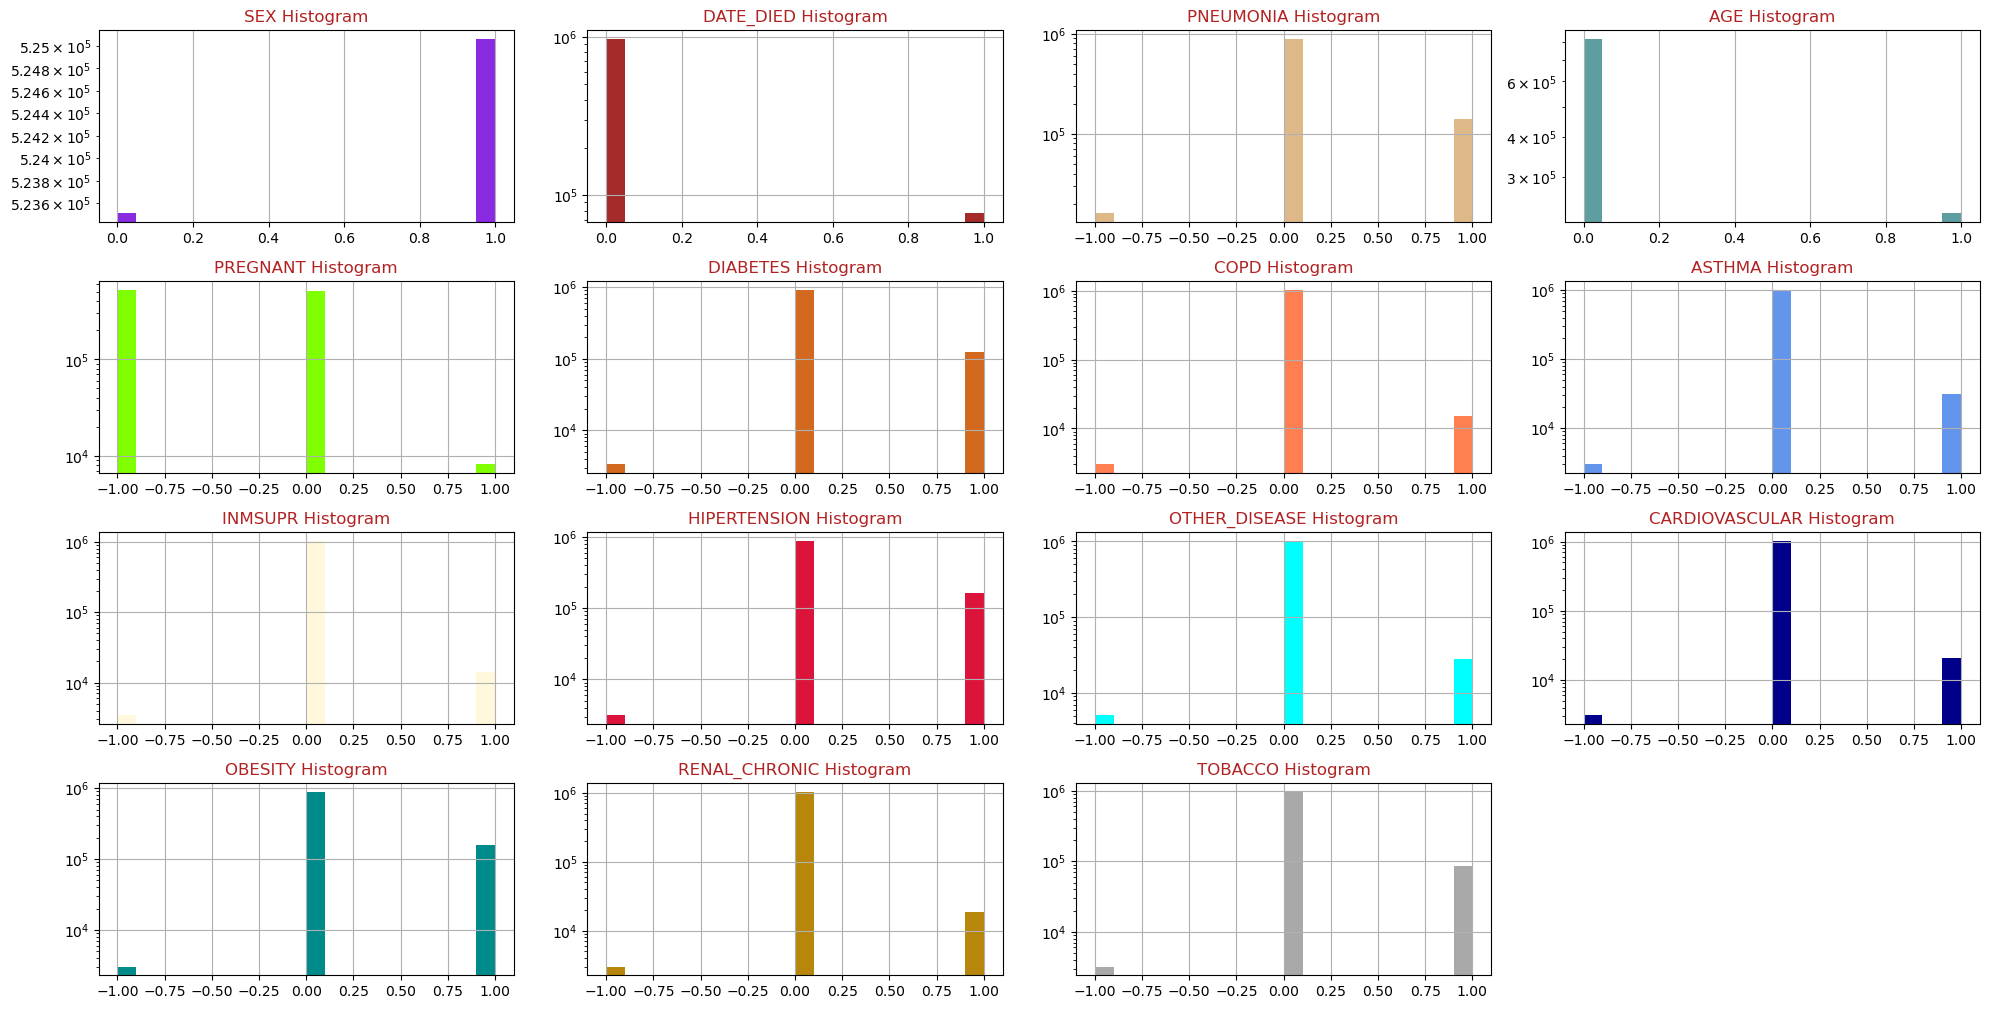

In [9]:
colors = list(mcolors.CSS4_COLORS.keys())[10:]
fig = plt.figure(figsize=(20,20))
for i, feature in enumerate(df.columns):
    f = fig.add_subplot(8, 4, i + 1)
    df[feature].hist(bins = 20, ax = f, facecolor = colors[i])
    f.set_title(feature + " Histogram", color = colors[35])
    f.set_yscale('log')
fig.tight_layout()
plt.show()

### Histogram of 'alive' cases

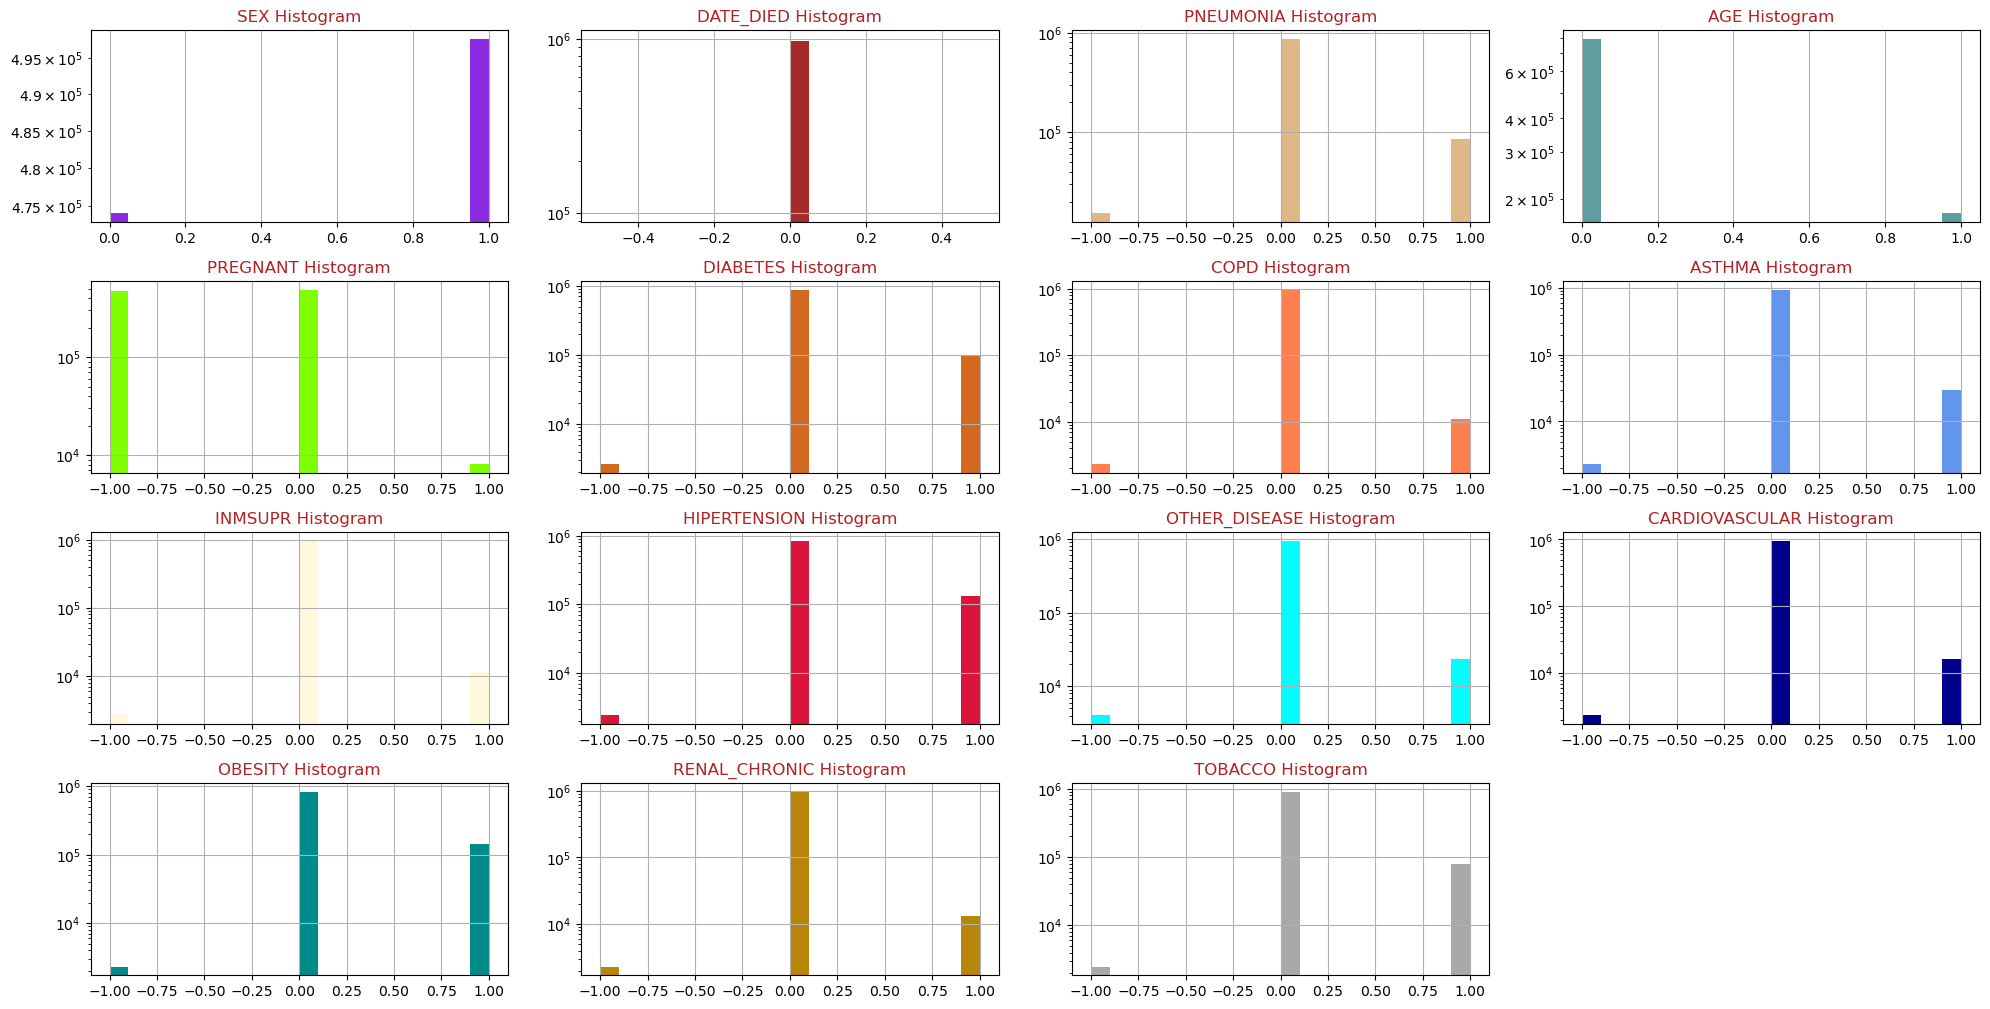

In [10]:
df_alive = df.loc[df['DATE_DIED']==0]

colors = list(mcolors.CSS4_COLORS.keys())[10:]
fig = plt.figure(figsize=(20,20))
for i, feature in enumerate(df_alive.columns):
    f = fig.add_subplot(8, 4, i + 1)
    df_alive[feature].hist(bins = 20, ax = f, facecolor = colors[i])
    f.set_title(feature + " Histogram", color = colors[35])
    f.set_yscale('log')
fig.tight_layout()
plt.show()

In [11]:
df_alive.head()

,SEX,DATE_DIED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO
5,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
6,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
7,1,0,1,1,0,1,0,0,1,1,0,0,0,1,0
8,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0
9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Histogram of 'dead' cases

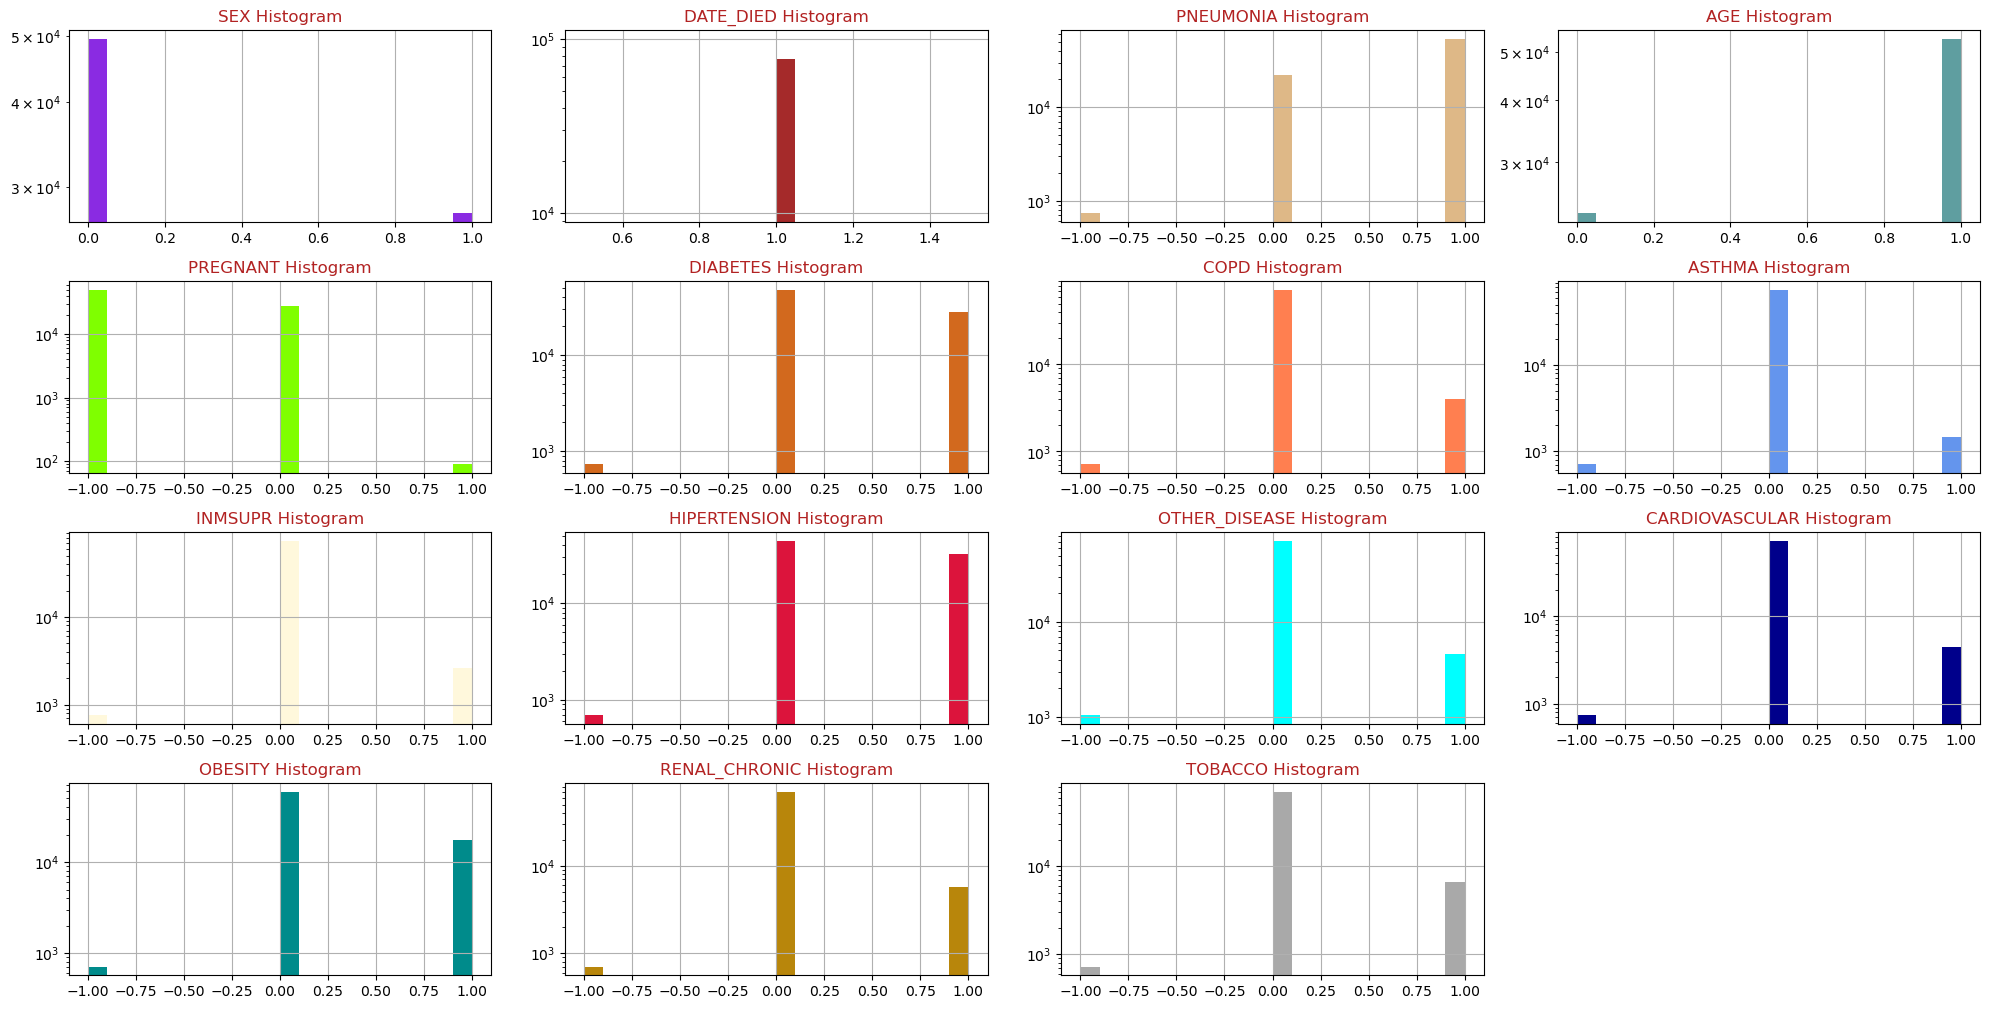

In [12]:
df_expired = df.loc[df['DATE_DIED']==1]

colors = list(mcolors.CSS4_COLORS.keys())[10:]
fig = plt.figure(figsize=(20,20))
for i, feature in enumerate(df_expired.columns):
    f = fig.add_subplot(8, 4, i + 1)
    df_expired[feature].hist(bins = 20, ax = f, facecolor = colors[i])
    f.set_title(feature + " Histogram", color = colors[35])
    f.set_yscale('log')
fig.tight_layout()
plt.show()

In [13]:
print('Number of pneumonia in dead cases:', sum(df['PNEUMONIA']==1))
print('Number of older age in dead cases:', sum(df['AGE']==1))

Number of pneumonia in dead cases: 140038
Number of older age in dead cases: 230232


In [14]:
df_expired.head()

,SEX,DATE_DIED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO
0,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0
1,0,1,1,1,-1,0,0,0,0,1,0,0,1,1,0
2,0,1,0,1,-1,1,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,1,-1,1,0,0,0,1,0,0,0,0,0


Next, let's take a look at a heatmap of our data to see if there are any correlations between our columns.

### Heatmap correlation

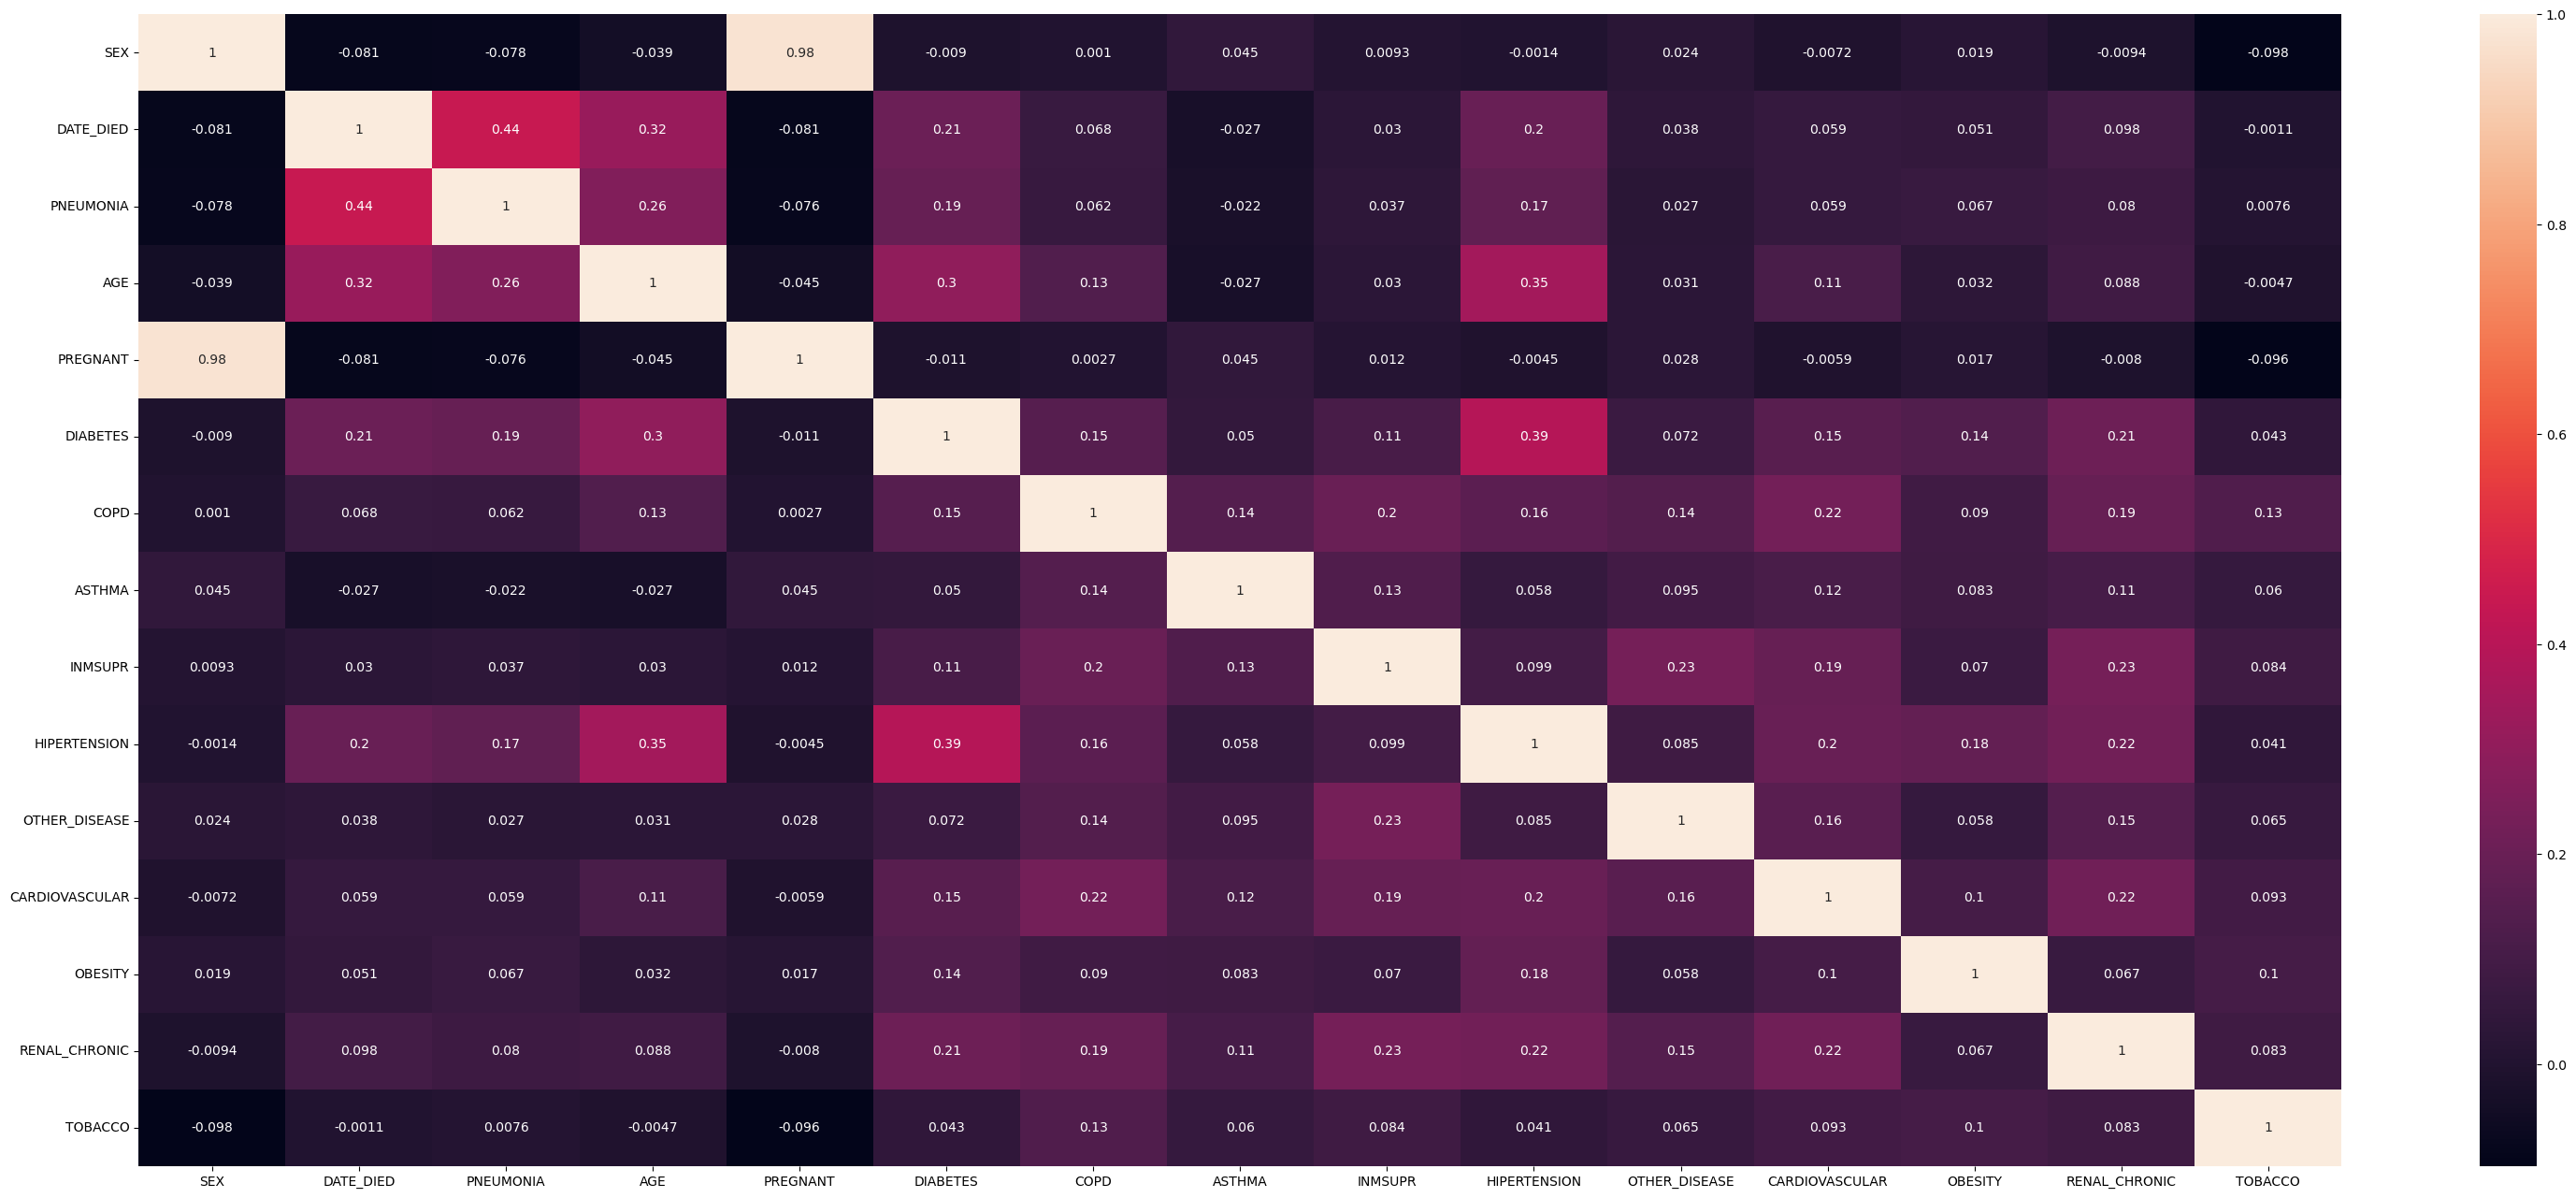

In [15]:
# Heatmap
plt.figure(figsize = (38, 16))
sns.heatmap(df.corr(), annot=True)
plt.show()

## Preliminary Analysis

Looking at these plots, we can see a lot of interesting results.
First of all, looking at both the df_alive and df_expired histograms, we can see that most of the nonsurvivors were male (value of 0). We can also see on the df_alive histogram that we have a lot of 0's for our pre-existing conditions, suggesting that the less pre-existing conditions the patient had prior to COVID19 infection, the higher their chances of survival.

Through our df_expired histogram, we can also see that a tremendous amount of patients that passed away were 55 or older, which indicates that age is a big indicator of whether a patient will survive or not. We also notive that nonsurvivors were impacted by conditions of pneumonia, hypertension and diabetes.

As expected, our heatmap shows the DATE_DIED column to have the highest correlation with age, pneumonia, diabetes, and hypertension.

# Logistic Regression

After reviewing and cleaning up our datasets, we are finally ready for our regression! Binary Logistic Regression was created rather than a linear regression as this model attempts to classify cases between binary values of 'alive' or 'dead'.

'DATE_DIED' will be our target. We will split our data between 80% training sets and 20% test sets, scale them and then do our logistic regression.

In [16]:
y = df.DATE_DIED
X = df.iloc[:, df.columns != 'DATE_DIED']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=12, stratify=y)

model = LogisticRegression();
model.fit(X_train, y_train)
train_accuracy = model.score(X_train, y_train)

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

model = LogisticRegression();
model.fit(X_train_scaled, y_train)
train_accuracy = model.score(X_train_scaled, y_train)
print(f'The accuracy for the training set is {100 * train_accuracy:.2f}%')
test_accuracy = model.score(X_test_scaled, y_test)
print(f'The accuracy for the test set is {100 * test_accuracy:.2f}%')

The accuracy for the training set is 93.09%
The accuracy for the test set is 93.04%


The accuracy for our training and test sets are quite low at around 93%. Let's take a look at our probabilities and create a confusion matrix to have a better understanding of how accurate our classifier is.

In [17]:
probs = model.predict_proba(X_test_scaled)
np.set_printoptions(precision=4, suppress=True)
probs[:5]

array([[0.2912, 0.7088],
       [0.9056, 0.0944],
       [0.9828, 0.0172],
       [0.9899, 0.0101],
       [0.8449, 0.1551]])

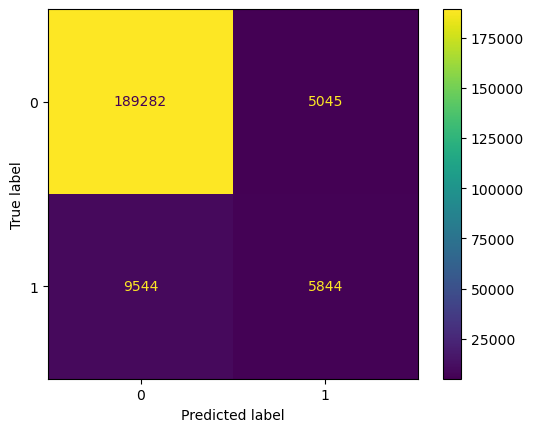

In [18]:
cm = confusion_matrix(y_test, model.predict(X_test_scaled))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

Based on our confusion matrix, 195126 (TP + TN) out of 209715 were classified correctly, which we already knew is 93.04% accurate. However, the amount of deaths being wrongly classified as "survived" is 9544 out of 209715 (4.5%) which is quite a bit high.

## Second Logistic Regression

Up above, we created a classifier that can predict whether a patient will survive a COVID19 infection solely based on their pre-existing conditions. What if we also take into account the kind of care they received during their infection? Let's see if we can have a higher accuracy with our classifier.

---

In [19]:
# Rebuild dataframe to contain binary values for 'ALIVE/DEAD' status
# Alive - 0
# Dead - 1
df = pd.read_csv('Covid Data.csv')
df = df.rename(columns={'DATE_DIED':'ALIVE_DEAD'})
df.loc[df['ALIVE_DEAD'] != '9999-99-99', 'ALIVE_DEAD'] = 1
df.loc[df['ALIVE_DEAD'] == '9999-99-99', 'ALIVE_DEAD'] = 0
df['ALIVE_DEAD'] = df['ALIVE_DEAD'].astype(np.int64)

#Again, we will be replacing 2's with 0's,
#Replace unknown values with -1, and categorize age between 55+ and 55 and under.
df = df.replace(2, 0)
df = df.replace(97, -1)
df = df.replace(99, -1)
df = df.replace(98, -1)

df["AGE"] = np.where(df["AGE"] < 55, 0, 1)

In [20]:
# Create training and testing set
df_y = df['ALIVE_DEAD']
df_x = df.iloc[:, df.columns!='ALIVE_DEAD']
df_x = scale(df_x)
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.20, random_state=12, stratify=df_y)

In [21]:
# Create and test Logistic Regression Model
model = LogisticRegression();
model.fit(x_train, y_train)
train_accuracy = model.score(x_train, y_train)
print(f'The accuracy for the training set is {100 * train_accuracy:.2f}%')
test_accuracy = model.score(x_test, y_test)
print(f'The accuracy for the test set is {100 * test_accuracy:.2f}%')

The accuracy for the training set is 94.57%
The accuracy for the test set is 94.55%


Our accuracy was a lot higher!!

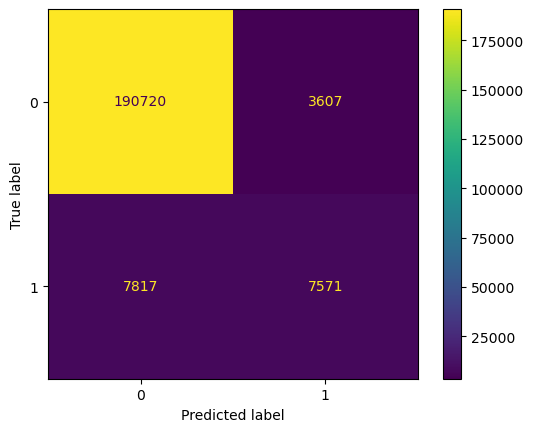

In [22]:
# Confusion Matrix
cm = confusion_matrix(y_test, model.predict(x_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

Looking at our confusion matrix, the amount of deaths mislabeled as survived decreased to 7817, which is down to 3.7%!

It appears that keeping all the columns gave us a more accurate classifier. Not foregoing the type of care the patients received gave our classifier a better understanding of who will survive a COVID19 infection.

# Third Logistic Regression (For Fun!)

Just for fun, how about if we made a classifier based solely on the type of care they received? This classifier will attempt to predict just how much the quality of care matters when it comes to helping a COVID19 patient survive. We will completely disregard the patient's pre-existing conditions.

In [23]:
# Rebuild dataframe to contain binary values for 'ALIVE/DEAD' status
# Alive - 0
# Dead - 1
df = pd.read_csv('Covid Data.csv')

#Drop pre-existing condition columns
df.drop('PNEUMONIA', axis = 1, inplace=True)
df.drop('AGE', axis = 1, inplace=True)
df.drop('PREGNANT', axis = 1, inplace=True)
df.drop('DIABETES', axis = 1, inplace=True)
df.drop('COPD', axis = 1, inplace=True)
df.drop('ASTHMA', axis = 1, inplace=True)
df.drop('INMSUPR', axis = 1, inplace=True)
df.drop('HIPERTENSION', axis = 1, inplace=True)
df.drop('OTHER_DISEASE', axis = 1, inplace=True)
df.drop('CARDIOVASCULAR', axis = 1, inplace=True)
df.drop('OBESITY', axis = 1, inplace=True)
df.drop('RENAL_CHRONIC', axis = 1, inplace=True)
df.drop('TOBACCO', axis = 1, inplace=True)
df.drop('CLASIFFICATION_FINAL', axis = 1, inplace=True)


df = df.rename(columns={'DATE_DIED':'ALIVE_DEAD'})
df.loc[df['ALIVE_DEAD'] != '9999-99-99', 'ALIVE_DEAD'] = 1
df.loc[df['ALIVE_DEAD'] == '9999-99-99', 'ALIVE_DEAD'] = 0
df['ALIVE_DEAD'] = df['ALIVE_DEAD'].astype(np.int64)

#Again, we will be replacing 2's with 0's, and unknown values with -1.
df = df.replace(2, 0)
df = df.replace(97, -1)
df = df.replace(99, -1)
df = df.replace(98, -1)

In [24]:
# Create training and testing set
df_y = df['ALIVE_DEAD']
df_x = df.iloc[:, df.columns!='ALIVE_DEAD']
df_x = scale(df_x)
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.20, random_state=12, stratify=df_y)

# Create and test Logistic Regression Model
model = LogisticRegression();
model.fit(x_train, y_train)
train_accuracy = model.score(x_train, y_train)
print(f'The accuracy for the training set is {100 * train_accuracy:.2f}%')
test_accuracy = model.score(x_test, y_test)
print(f'The accuracy for the test set is {100 * test_accuracy:.2f}%')

The accuracy for the training set is 94.48%
The accuracy for the test set is 94.50%


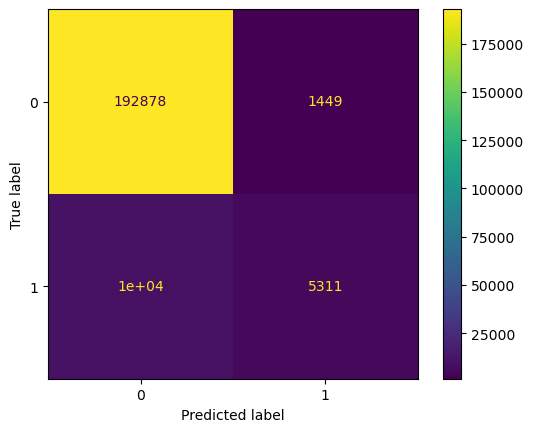

In [25]:
# Confusion Matrix
cm = confusion_matrix(y_test, model.predict(x_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

Surprisingly, our accuracy was pretty high. However, our False Negatives with this classifier is the highest between the three.